# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm
from sklearn.tree import DecisionTreeClassifier

import sklearn.model_selection
from scipy.stats import randint as sp_randint

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

import sklearn.pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


In [4]:
X_competencia

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
501,0.2828,2.0610,1.0889,-0.7976,0.6819,-0.0531,0.3860,...,0.6734,0.3584,1.0187,1.4373,-0.7069,0.9051,-0.5420
502,-1.1895,1.1622,0.4257,0.7102,0.2699,1.1044,1.7634,...,-2.1822,0.0875,-0.6501,-1.7537,0.6584,-0.4861,-0.6913
503,-0.2730,-0.2018,0.4408,-1.0598,-0.3892,2.5573,0.1915,...,2.5449,-1.1552,1.0447,-0.6057,-2.2056,-0.4326,-0.2387
504,0.2006,0.5208,0.0377,-0.0886,1.5035,-1.6581,-1.1057,...,-1.7424,-0.5942,0.0929,0.4501,1.7539,-0.3211,2.0208
505,-0.6236,-1.2563,-0.4989,-2.3673,0.6763,-1.3346,0.9431,...,-0.5637,0.5153,0.2446,2.4462,0.3621,-0.2002,0.2214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.1862,-0.4901,0.4467,0.0266,-0.4089,0.6472,0.3563,...,-0.4666,-1.9118,-0.0137,-0.5356,-1.5728,1.0976,-0.1557
4996,0.3290,-0.1691,-1.0451,-1.1327,-0.7251,1.8375,1.0902,...,1.2854,-1.6045,0.1122,-0.4087,0.8175,-0.2249,0.6526
4997,-1.6937,-0.1262,-0.3666,-0.5854,0.1751,0.0770,0.0218,...,-0.4626,-1.1507,-0.1373,-0.7572,0.4323,-1.0987,-1.2257


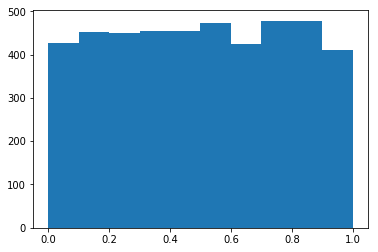

In [5]:
plt.hist(np.array(y_competencia_ejemplo))
plt.show()

## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

In [6]:
# EJERCICIO 1. 

np.random.seed(1234)


########################################################
## AQUI VA SU CODIGO
# X_dev, X_eval, y_dev, y_eval = X, X, y, y  # cambiar esta línea si lo consideran necesario

X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=0.2, stratify = y)
#X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, stratify=y, test_size=0.2)

# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas
#########################################################

X_dev: (400, 200), y_dev: (400, 1) para desarrollo
X_eval: (100, 200), y_eval: (100, 1) para evaluación


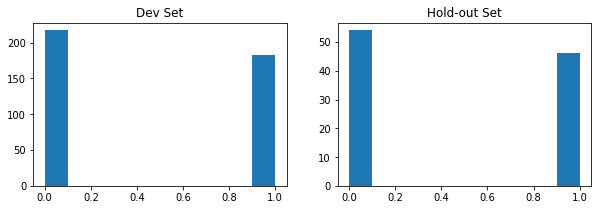

In [7]:
print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.title('Dev Set')
plt.subplot(1,2,2)
plt.hist(np.array(y_eval))  # muestra un histograma para la distribución de y.
plt.title('Hold-out Set')
plt.show()

Siempre los esta separando igual. Esto es porque el np.random.seed(1234) me fija el random state. Si lo comento, cambia. Cuando lo cambio, aleatoriamente me pueden quedar balanceadas distinto las poblaciones. Eso se puede prefijar con el atributo stratify del split.

In [8]:
X_eval

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
220,-0.0039,-0.2219,0.2256,1.6150,-0.4596,0.6577,-1.1396,...,-0.4988,-0.3800,1.0326,0.2300,-0.9009,-0.5356,-0.0300
322,-0.8332,0.9293,-1.4241,-0.1081,-1.2750,-0.3981,-1.5465,...,-1.6901,-0.3313,-1.5866,-2.2848,0.5458,-0.4905,-0.3226
389,1.2564,-0.4148,0.4160,-1.4830,-0.7953,-0.2643,1.0246,...,-0.2121,-0.4958,-0.7882,-0.1594,0.9132,0.1843,-0.0624
437,0.3445,-0.4370,0.2835,-1.3442,0.4400,0.5750,0.3196,...,0.8992,-0.0693,-0.0891,-1.3170,-1.2570,-1.6374,-1.1743
51,-0.5469,-0.6052,0.9580,-0.7625,1.2604,-0.9200,-0.1145,...,-0.4350,2.6315,1.0384,-1.2406,0.1974,-0.7332,0.7493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-0.6747,0.4102,-1.2927,-1.0565,-0.7854,1.2638,0.2930,...,0.3013,-0.9610,-1.0328,-1.6097,-0.7077,0.0332,1.3322
380,-0.0467,0.7315,0.4067,0.5575,1.1518,-0.7761,0.4583,...,-0.3509,1.0093,1.0415,-1.1233,1.7720,-0.8640,-1.7260
22,-0.8160,0.4509,0.6044,-2.2624,-0.4594,-0.0256,-0.4001,...,-1.0719,0.9182,-0.0803,-0.1797,-0.6924,0.6430,-1.1868


Probar de splitear para distintos random states con el stratify y sin. 

Habria que ver que pasaria si usaran un balance distinto de datos para la competencia. O si el balance de los datos en el entrenamiento te condiciona mucho. Si los datos estan muy desbalanceados, es mas estable el auc de la curva precision recall? Igual los datos no estan casi desbalanceados. Pero si lo estuvieran, habria que ver si se le puede dar mas peso a la clase minoria, como pasa con logistic regression con el weight class. Aunque quizas splitear a ciegas es mejor para no meter proporcionalidad. Se podria ver como cambia el auc usando distintos grupos de hold out. O sea, el hold out total de 0.2 se lo puede dividir en 1 hold out de 0.1 y lo restante separarlo en 2 grupos completamente desbalanceados o en 3, agregando uno balanceado pero menor. De esa manera puedo hacer un análisis mas profundo para predecir cuanto va a dar la roc auc. Aunque el tema ahi es que pierdo tamaño del set. Y el X competencia es largo, tiene 4500 datos. Pero no sabemos si esta balanceado porque el y competencia que dieron es de ejemplo y el real lo tienen ellos.

Tambien, para predecir mejor que tan generalizable es el modelo, en lugar de separar el hold out set en varios independientes, se puede hacer bootstrapping. Manteniendo el mismo split y el mismo modelo, se pueden hacer subsets random del dev set y del holdout set y medir las aucs. Ahora no se va a tener un unico valor, si no que se va a tener una distribucion con su estadistica. Si defino que los subsets resampleados para el bootstrapping tengan el mismo stratify que el grupo total, voy a reducir la varianza producida por la estratificacion variable de los resamples. Pero quizas esto no es conveniente ya que en realidad no se si ellos van a usar una muestra igual de estratificada. Y deberia ser independiente de eso mi prediccion de cuan generalizable es el modelo.

Otra forma de ver generalizacion es repetir el proceso completo de split entrenamiento etc. Y entonces puedo sacar una estadistica, pero no voy a tener un unico modelo. Salvo que me quede con el modelo que tenga un auc igual a la mediana. Y esto esta bueno para ver como que tan distintos van a ser los modelos segun si elegi un split random especifico de casualidad u otro. Entonces puedo estudiar robustez. Y si me quedo con el modelo de la mediana, me puedo fijar la performance en train y test. Y capaz a ese modelo y split hacerle bootstrapping.

Y que pasa con las probabilidades de cada instancia? van a ser estables?

Otra cosa que se puede hacer es ver si el set de hold out tiene la misma info que el de entrenamiento. Para esto, se usa como "y" el set al que pertenece y se evalua un clasificador a ver si puede diferenciar ambos grupos. Si no puede, la info de los 2 grupos es la misma.

Para el cross validation se puede hacer kfold o one leave out, que va a ser mas costoso.

Revisar metodos de calibracion


## Features

Me fijo si todos los atributos son numericos

In [9]:
sum(X_dev.dtypes == 'float64')/len(X_dev.dtypes)

1.0

Todos los atributos son numericos

Me fijo si hay alguno vacio

In [10]:
X_dev.isnull().sum().sum()

0

No hay ninguno vacio

Hago histogramas para todas las features

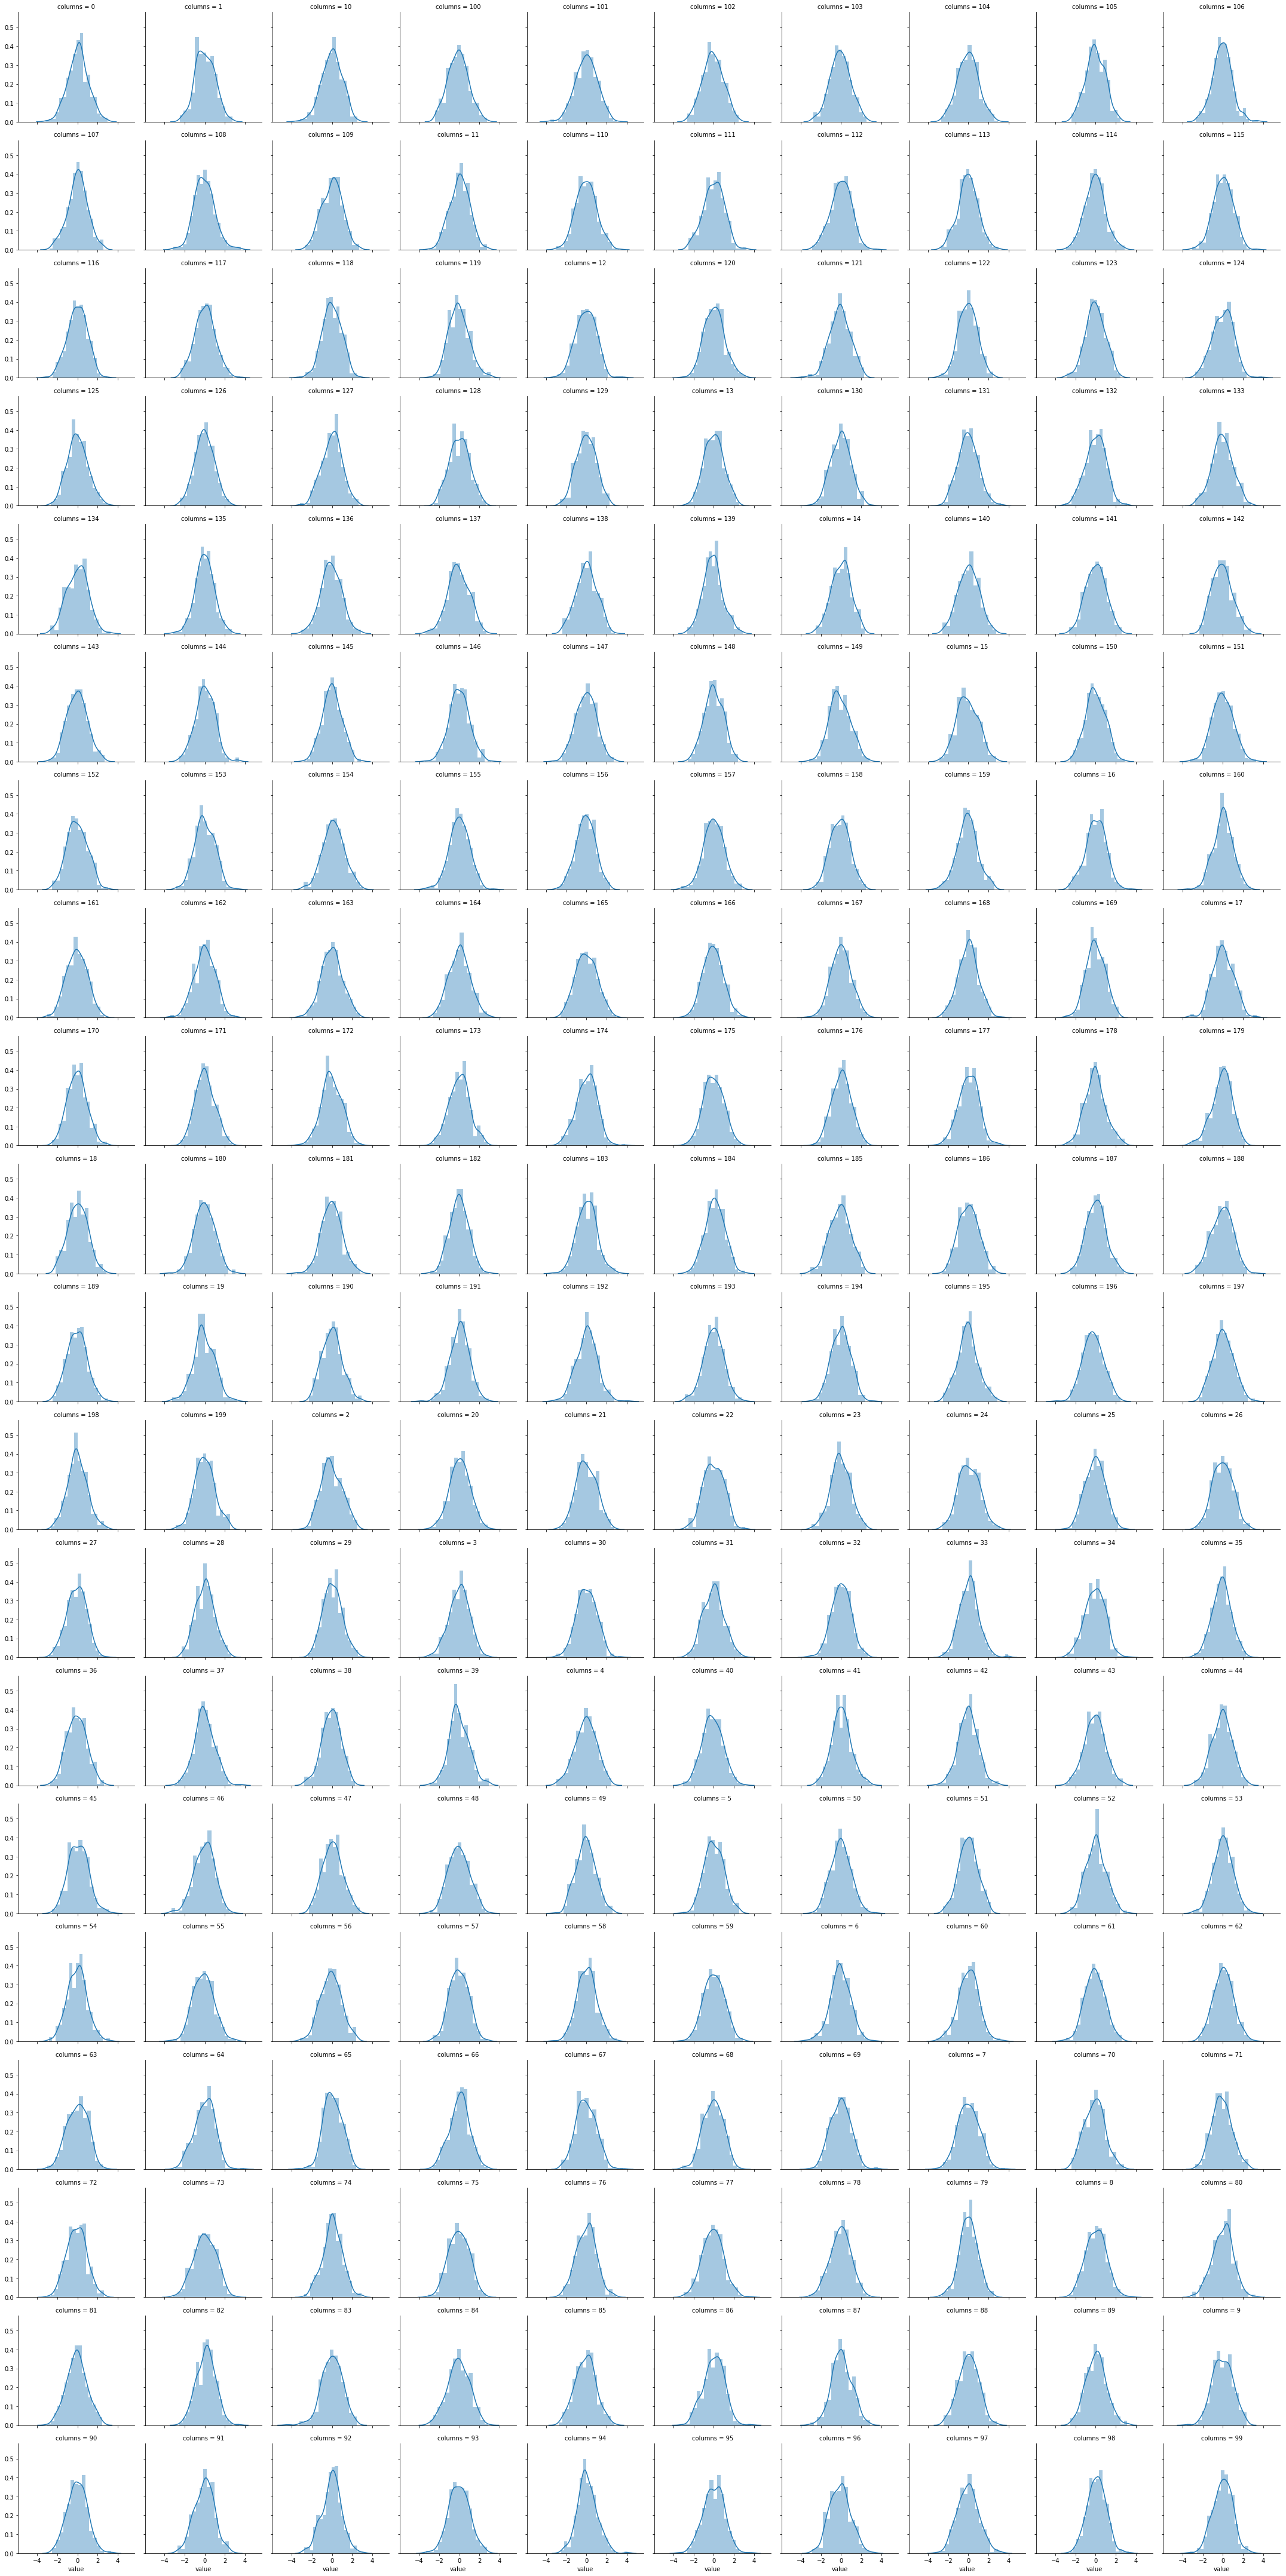

In [11]:
g = sns.FacetGrid(X_dev.melt(var_name='columns'), col='columns', col_wrap=10)
g = (g.map(sns.distplot, 'value'))

In [12]:
# X_dev.hist(figsize=(20,20))
# plt.show()

Que parecen ser distribuciones bastante normales. Pero si vieramos que tienen skewness y quisieramos sacarnoslo de encima podriamos transformar las features aplicandole el logaritmo.

Se podria igual aplicar un test para ver normalidad de los datos

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

Ej 2.1

In [13]:
arbol_2_1 = DecisionTreeClassifier(max_depth=3)
arbol_2_1.fit(X_dev, y_dev)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Y puedo calcular la curva roc

In [14]:
from sklearn.metrics import roc_curve

In [15]:
y_pred_proba = arbol_2_1.predict_proba(X_eval)[:,1]

In [16]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba)

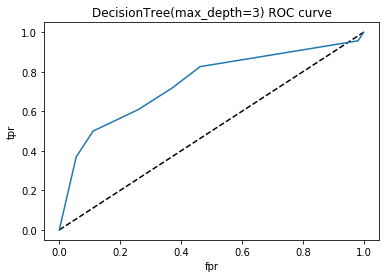

In [17]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('DecisionTree(max_depth=3) ROC curve')
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_eval,y_pred_proba)

0.7419484702093398

Aca tambien se puede mostrar el rol del random state

Ej 2.2

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8245,0.6296,0.8200,0.6204
2,0.8464,0.7407,0.8418,0.7377
3,0.8406,0.6875,0.8325,0.6697
4,0.8255,0.6962,0.8248,0.6983
5,0.8442,0.6835,0.8421,0.6822


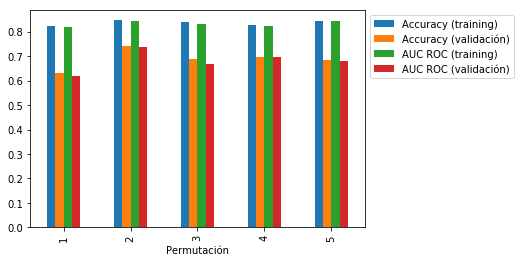

In [19]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

np.random.seed(SEED) # esto lo agregue para fijar el random state

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
## AQUI VA SU CODIGO 
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
splits = cv.split(X_dev, y_dev)
#scores = pd.DataFrame(columns=['accuracies_training','accuracies_validation','aucs_training','aucs_validation'])
for train_idxs, val_idxs in splits:
    arbol_2_2 = DecisionTreeClassifier(max_depth=3)
    arbol_2_2.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
    y_train = y_dev.iloc[train_idxs]
    y_val = y_dev.iloc[val_idxs]
    y_train_pred = arbol_2_2.predict(X_dev.iloc[train_idxs])
    y_val_pred = arbol_2_2.predict(X_dev.iloc[val_idxs])
#    scores = scores.append(pd.Series({
#        'accuracies_training': sklearn.metrics.accuracy_score(y_train, y_train_pred),
#        'accuracies_validation': sklearn.metrics.accuracy_score(y_val, y_val_pred),
#        'aucs_training': sklearn.metrics.roc_auc_score(y_train, y_train_pred),
#        'aucs_validation': sklearn.metrics.roc_auc_score(y_val, y_val_pred)
#     }), ignore_index=True)
    accuracies_training.append(sklearn.metrics.accuracy_score(y_train, y_train_pred))
    accuracies_validation.append(sklearn.metrics.accuracy_score(y_val, y_val_pred))
    aucs_training.append(sklearn.metrics.roc_auc_score(y_train, y_train_pred))
    aucs_validation.append(sklearn.metrics.roc_auc_score(y_val, y_val_pred))
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training     # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracies_validation   # cambiar por accuracies_validation
df["AUC ROC (training)"] = aucs_training      # cambiar por aucs_training
df["AUC ROC (validación)"] = aucs_validation    # cambiar por aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Aca tambien se pueden mostrar las distintas formas de CV

Ej 2.3

In [20]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
np.random.seed(SEED)
for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
#         CODIGO AQUI.
        arbol_2_3 = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
        arbol_2_3.fit(X_dev, y_dev)    
        y_dev_pred = arbol_2_3.predict(X_dev)
        y_eval_pred = arbol_2_3.predict(X_eval)
        resultados_training.append(sklearn.metrics.roc_auc_score(y_dev, y_dev_pred))
        resultados_validation.append(sklearn.metrics.roc_auc_score(y_eval, y_eval_pred))
#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8068,0.6965
1,5,Gini,0.9473,0.6610
2,Inifinito,Gini,1.0000,0.6888
3,3,Ganancia de Información,0.7882,0.6795
4,5,Ganancia de Información,0.9121,0.5946
5,Inifinito,Ganancia de Información,1.0000,0.6425


## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

## KNN

Exploro un poco los parametros que en este caso es el numero de vecinos.

In [21]:
## Da error esto
#n_neighbors = range(1, 101)
#knn_scores = []
#for k in n_neighbors:
#    knn = KNeighborsClassifier(n_neighbors=k)
#    scores = sklearn.model_selection.cross_val_score(knn, X_dev, y_dev, cv=5, scoring='accuracy')
#    knn_scores.append(scores.mean())
#print(knn_scores)

El problema es que en lugar de usar fit, estoy usando la funcion cross_val_score y esa funcion espera una lista y no un dataframe de pandas

Entonces puedo usar arrays

In [22]:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

In [23]:
# n_neighbors = range(1, 31) # este era el que habia encontrado en ejemplos
n_neighbors = range(1, 101)
knn_scores = []
for k in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = sklearn.model_selection.cross_val_score(knn, X_dev_np, y_dev_np, cv=5, scoring='accuracy')
    knn_scores.append(scores.mean())
print(knn_scores)

[0.6127324581965932, 0.6354231129864042, 0.6677687919987498, 0.6854918737302703, 0.7204008438818565, 0.735403969370214, 0.7478438037193311, 0.7353723238005938, 0.7229024066260352, 0.7277789498359117, 0.7276230661040788, 0.7500937646507266, 0.7352789498359119, 0.7500922019065479, 0.7452172214408501, 0.7426871386154087, 0.7326847944991405, 0.727841459603063, 0.7527820753242696, 0.7502820753242695, 0.7552512111267387, 0.7499695264885139, 0.7627219096733865, 0.762658618534146, 0.7652836380684482, 0.7703785747773091, 0.7752535552430067, 0.770347710579778, 0.7727527738709173, 0.7627836380684483, 0.7602828566963588, 0.7603770120331302, 0.7478129395218003, 0.7478445850914206, 0.7552820753242694, 0.7576887013595874, 0.7577820753242694, 0.750312158149711, 0.75278129395218, 0.752687919987498, 0.7451554930457883, 0.7528121581497109, 0.7453113767776216, 0.750312158149711, 0.7478430223472418, 0.7477805125800907, 0.7502180028129395, 0.7601570557899671, 0.7577504297546491, 0.757687919987498, 0.7602820

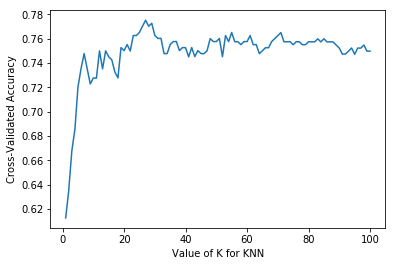

In [24]:
plt.plot(n_neighbors, knn_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

Otra opcion es usar el atributo values del dataframe como input

In [25]:
y_dev.values

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
    

Pero en realidad necesita que el y sea un array de 1D

In [26]:
y_dev.values.ravel()

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,

In [27]:
# n_neighbors = range(1, 31) # este era el que habia encontrado en ejemplos
n_neighbors = range(1, 101)
knn_scores = []
for k in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = sklearn.model_selection.cross_val_score(knn, X_dev.values, y_dev.values.ravel(), cv=5, scoring='accuracy')
    knn_scores.append(scores.mean())
print(knn_scores)

[0.6127324581965932, 0.6354231129864042, 0.6677687919987498, 0.6854918737302703, 0.7204008438818565, 0.735403969370214, 0.7478438037193311, 0.7353723238005938, 0.7229024066260352, 0.7277789498359117, 0.7276230661040788, 0.7500937646507266, 0.7352789498359119, 0.7500922019065479, 0.7452172214408501, 0.7426871386154087, 0.7326847944991405, 0.727841459603063, 0.7527820753242696, 0.7502820753242695, 0.7552512111267387, 0.7499695264885139, 0.7627219096733865, 0.762658618534146, 0.7652836380684482, 0.7703785747773091, 0.7752535552430067, 0.770347710579778, 0.7727527738709173, 0.7627836380684483, 0.7602828566963588, 0.7603770120331302, 0.7478129395218003, 0.7478445850914206, 0.7552820753242694, 0.7576887013595874, 0.7577820753242694, 0.750312158149711, 0.75278129395218, 0.752687919987498, 0.7451554930457883, 0.7528121581497109, 0.7453113767776216, 0.750312158149711, 0.7478430223472418, 0.7477805125800907, 0.7502180028129395, 0.7601570557899671, 0.7577504297546491, 0.757687919987498, 0.7602820

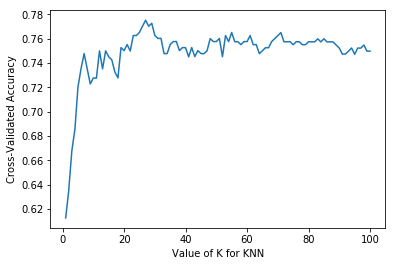

In [28]:
plt.plot(n_neighbors, knn_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

Ahora pruebo de usar el grid search en lugar del for manual

Para eso tengo que definir los parametros como un diccionario

In [29]:
n_neighbors = list(range(1, 101))
param_grid = dict(n_neighbors=n_neighbors)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]}


In [30]:
knn = KNeighborsClassifier()
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Uso el atributo cv results ('grid_score_' ya no existe mas en las versiones actuales)

In [31]:
grid.cv_results_['mean_test_score']

array([0.6125, 0.635 , 0.6675, 0.685 , 0.72  , 0.735 , 0.7475, 0.735 ,
       0.7225, 0.7275, 0.7275, 0.75  , 0.735 , 0.75  , 0.745 , 0.7425,
       0.7325, 0.7275, 0.7525, 0.75  , 0.755 , 0.75  , 0.7625, 0.7625,
       0.765 , 0.77  , 0.775 , 0.77  , 0.7725, 0.7625, 0.76  , 0.76  ,
       0.7475, 0.7475, 0.755 , 0.7575, 0.7575, 0.75  , 0.7525, 0.7525,
       0.745 , 0.7525, 0.745 , 0.75  , 0.7475, 0.7475, 0.75  , 0.76  ,
       0.7575, 0.7575, 0.76  , 0.745 , 0.7625, 0.7575, 0.765 , 0.7575,
       0.7575, 0.755 , 0.7575, 0.7575, 0.7625, 0.755 , 0.755 , 0.7475,
       0.75  , 0.7525, 0.7525, 0.7575, 0.76  , 0.7625, 0.765 , 0.7575,
       0.7575, 0.7575, 0.755 , 0.7575, 0.7575, 0.755 , 0.755 , 0.7575,
       0.7575, 0.7575, 0.76  , 0.7575, 0.76  , 0.7575, 0.7575, 0.7575,
       0.755 , 0.7525, 0.7475, 0.7475, 0.75  , 0.7525, 0.7475, 0.7525,
       0.7525, 0.755 , 0.75  , 0.75  ])

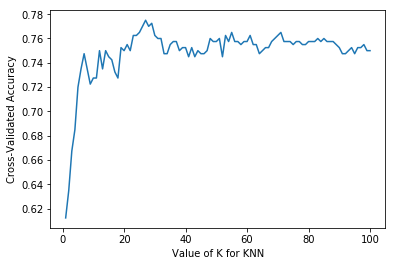

In [32]:
plt.plot(n_neighbors, grid.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

Que en ppio parece que hacer el grid search o usar el cross val score y hacer el for manual dan lo mismo por el grafico, pero dan un poco distinto. Tambien se observa que el GridSearchCV redondea los resultados, pero esto no explica las diferencias

Y los mejores parametros, scores, y el correspondiente estimador son

In [33]:
print(grid.best_score_)

# Dictionary containing the parameters (k) used to generate that score
print(grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid.best_estimator_)

0.775
{'n_neighbors': 27}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=27, p=2,
           weights='uniform')


Pero estoy usando accuracy como medida de performance. Nos recomiendan usar el roc auc

In [34]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
param_grid = dict(n_neighbors=n_neighbors)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

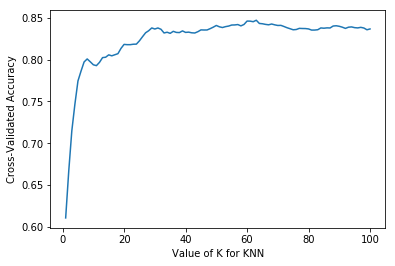

In [35]:
plt.plot(n_neighbors, grid.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [36]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8471357668450691
{'n_neighbors': 63}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=63, p=2,
           weights='uniform')


Es interesante que esta medida de performance es menos fluctuante y mas suave. Y por eso, me encuentra que el mejor numero de vecinos es mayor

Podemos comparar los resultados de multiples metricas. Para multi metric scoring hay que definirle explicitamente el parametro refit, ya sea con una metrica como 'AUC' o poniendo False

In [37]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
param_grid = dict(n_neighbors=n_neighbors)# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit=False, iid='True') # return_train_score=True
grid.fit(X_dev.values, y_dev.values.ravel())
results = grid.cv_results_

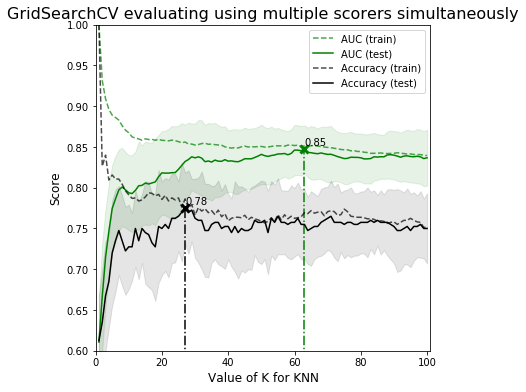

In [38]:
plt.figure(figsize=(6, 6))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("Value of K for KNN", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 101)
ax.set_ylim(0.6, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_neighbors'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
#plt.grid('off')
plt.show()


Y si para el refit hubiesemos puesto 'AUC'

In [39]:
knn = KNeighborsClassifier()
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy'}
# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='AUC', iid='True') # return_train_score=True
grid.fit(X_dev.values, y_dev.values.ravel())
results = grid.cv_results_

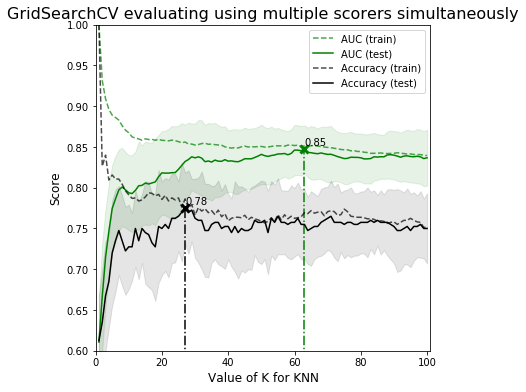

In [40]:
plt.figure(figsize=(6, 6))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("Value of K for KNN", fontsize=12)
plt.ylabel("Score", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 101)
ax.set_ylim(0.6, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_neighbors'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
#plt.grid('off')
plt.show()


Tambien seria interesante ver si hay mas parametros ademas del n_neighbors. Por ejemplo el weight

In [41]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
weights = ['uniform', 'distance']
param_grid = dict(n_neighbors=n_neighbors, weights=weights)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [42]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8480346956364399
{'n_neighbors': 63, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=63, p=2,
           weights='distance')


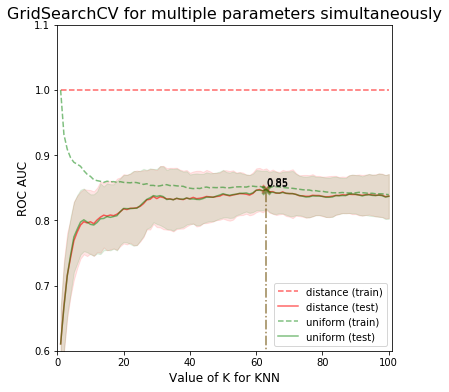

In [43]:
plt.figure(figsize=(6, 6))
plt.title("GridSearchCV for multiple parameters simultaneously",
          fontsize=16)

plt.xlabel("Value of K for KNN", fontsize=12)
plt.ylabel("ROC AUC", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 101)
ax.set_ylim(0.6, 1.1)

for weight, color in zip(sorted(weights), ['r', 'g']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = grid.cv_results_['mean_%s_score' % (sample)][np.array(grid.cv_results_['param_weights']) == weight]
        sample_score_std = grid.cv_results_['std_%s_score' % (sample)][np.array(grid.cv_results_['param_weights']) == weight]
        ax.fill_between(n_neighbors, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(n_neighbors, sample_score_mean, style, color=color,
                alpha=0.6 if weight == 'distance' else 0.5,
                label="%s (%s)" % (weight, sample))

    best_index = np.argmax(grid.cv_results_['mean_test_score'][np.array(grid.cv_results_['param_weights']) == weight])
    best_score = grid.cv_results_['mean_test_score'][np.array(grid.cv_results_['param_weights']) == weight][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([n_neighbors[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8, alpha=0.4)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (n_neighbors[best_index], best_score + 0.005))

plt.legend(loc="best")
#plt.grid('off')
plt.show()


O la metrica de distancia

In [44]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
metrics= ['minkowski','euclidean', 'cityblock']
param_grid = dict(n_neighbors=n_neighbors, metric=metrics)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'metric': ['minkowski', 'euclidean', 'cityblock']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

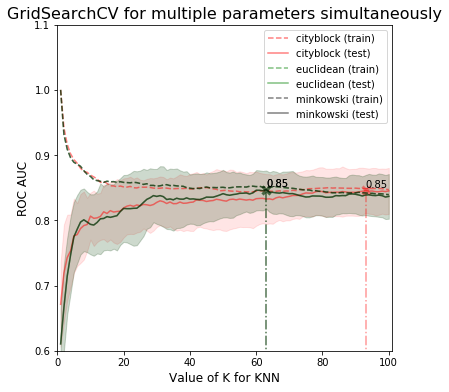

In [45]:
plt.figure(figsize=(6, 6))
plt.title("GridSearchCV for multiple parameters simultaneously",
          fontsize=16)

plt.xlabel("Value of K for KNN", fontsize=12)
plt.ylabel("ROC AUC", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 101)
ax.set_ylim(0.6, 1.1)

for metric, color in zip(sorted(metrics), ['r', 'g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = grid.cv_results_['mean_%s_score' % (sample)][np.array(grid.cv_results_['param_metric']) == metric]
        sample_score_std = grid.cv_results_['std_%s_score' % (sample)][np.array(grid.cv_results_['param_metric']) == metric]
        ax.fill_between(n_neighbors, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(n_neighbors, sample_score_mean, style, color=color,
                alpha=0.5, label="%s (%s)" % (metric, sample))

    best_index = np.argmax(grid.cv_results_['mean_test_score'][np.array(grid.cv_results_['param_metric']) == metric])
    best_score = grid.cv_results_['mean_test_score'][np.array(grid.cv_results_['param_metric']) == metric][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([n_neighbors[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8, alpha=0.4)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (n_neighbors[best_index], best_score + 0.005))

plt.legend(loc="best")
#plt.grid('off')
plt.show()


Las metricas euclidean y minkowski se superponen, y parecen funcionar mejor que cityblock

Me quedo entonces con los parametros de metric y weights default que son minkowski y uniform

Ahora pruebo leaf_size

In [46]:
knn = KNeighborsClassifier()
n_neighbors = [60] #list(range(1, 101))
leaf_size = list(range(1, 41))
param_grid = dict(n_neighbors=n_neighbors, leaf_size=leaf_size)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [60], 'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

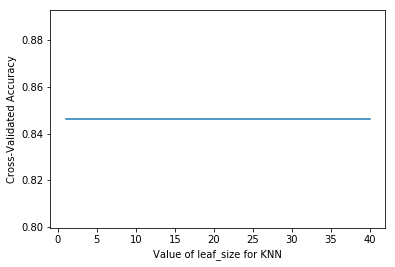

In [47]:
plt.plot(leaf_size, grid.cv_results_['mean_test_score'])
plt.xlabel('Value of leaf_size for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

Se ve que el leaf_size para este caso no esta haciendo nada, probablemente porque no este usando ningun algoritmo que use el leaf_size. Entonces, con variar el n_neighbors esta bien

Tambien esta bueno para ver las performances de multiples parametros usar heat maps. Esto es para 2 hyper parametros, pero se pueden graficar de a pares. O tambien se pueden hacer plots de relieve

Randomized Search CV

In [48]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
weights = ['uniform', 'distance']
param_dist = dict(n_neighbors=n_neighbors, weights=weights)
rand = sklearn.model_selection.RandomizedSearchCV(knn, param_dist, cv=5, scoring='roc_auc', n_iter=10, iid='True')
rand.fit(X_dev.values, y_dev.values.ravel())
#rand.grid_scores_

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid='True', n_iter=10, n_jobs=None,
          param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [49]:
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.8387731375667424
{'weights': 'distance', 'n_neighbors': 87}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=87, p=2,
           weights='distance')


Lo corro varias veces

In [50]:
best_scores = []
best_n = []
n_neighbors = list(range(1, 101))
weights = ['uniform', 'distance']
param_dist = dict(n_neighbors=n_neighbors, weights=weights)
for _ in list(range(20)):
    knn = KNeighborsClassifier()
    rand = sklearn.model_selection.RandomizedSearchCV(knn, param_dist, cv=5, scoring='roc_auc', n_iter=10, iid='True')
    rand.fit(X_dev.values, y_dev.values.ravel())
    best_scores.append(rand.best_score_)
    best_n.append(rand.best_params_['n_neighbors'])
print(best_scores)
print(best_n)

[0.8407233991390968, 0.842930427785079, 0.8471357668450691, 0.8451476820372169, 0.8421842184414859, 0.8407233991390968, 0.8472688465421023, 0.8472688465421023, 0.8472688465421023, 0.8392799300357442, 0.8408862013440502, 0.8416797909167094, 0.839782968750992, 0.8460682326089304, 0.8419743812258348, 0.8460682326089304, 0.8460682326089304, 0.8451476820372169, 0.8426228719469998, 0.8436364191887448]
[56, 65, 63, 62, 66, 56, 61, 61, 61, 51, 50, 67, 94, 61, 57, 61, 61, 62, 68, 68]


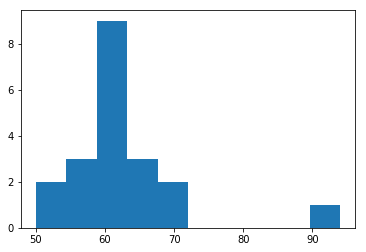

In [51]:
plt.hist(best_n);

In [52]:
print("mean: {}".format(np.mean(best_n)))
print("std: {:.2f}".format(np.std(best_n)))
print("median: ", np.median(best_n))

mean: 62.55
std: 8.69
median:  61.0


Y tambien puedo correr para varios n_iter

In [53]:
best_n = []
n_neighbors = list(range(1, 101))
weights = ['uniform', 'distance']
param_dist = dict(n_neighbors=n_neighbors, weights=weights)
n_iter = np.linspace(10,100,4)
for n in n_iter:
    for _ in list(range(10)):
        knn = KNeighborsClassifier()
        rand = sklearn.model_selection.RandomizedSearchCV(knn, param_dist, cv=5, scoring='roc_auc', n_iter=n, iid='True')
        rand.fit(X_dev.values, y_dev.values.ravel())
        best_scores.append(rand.best_score_)
        best_n.append(rand.best_params_['n_neighbors'])    

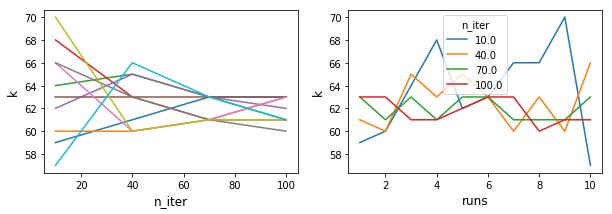

In [54]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(n_iter,np.array(best_n).reshape(len(n_iter),10))
plt.xlabel('n_iter', fontsize=12)
plt.ylabel('k', fontsize=12)
plt.subplot(1,2,2)
plt.plot(np.linspace(1,10,10),np.array(best_n).reshape(len(n_iter),10).T)
plt.xlabel('runs', fontsize=12)
plt.ylabel('k', fontsize=12)
plt.legend(n_iter, title='n_iter')
plt.show()

Habria que hacer la cuenta del tamaño de la grilla del grid search, en base a eso probar con varios n_iter y comparar tiempos. Seguro que encuentro que a partir de un n_iter empiezo a tener una solucion estable y ese es mucho menor que la cantidad de datos que exploro con la grilla. Ver de comparar tiempos de ejecucion

En el caso de que solo busquemos sintonizar el parametro k, para el grid tengo 100 y para el random podemos usar un n_iter=20 y estamos probando en la 5ta parte de los valores 

In [55]:
import time
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
param_grid = dict(n_neighbors=n_neighbors)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
start = time.time()
grid.fit(X_dev.values, y_dev.values.ravel())
print('grid search took {:.2f} seconds'.format(time.time() - start))
print(grid.best_params_)
rand = sklearn.model_selection.RandomizedSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_iter=20, iid='True')
start = time.time()
rand.fit(X_dev.values, y_dev.values.ravel())
print('random search took {:.2f} seconds'.format(time.time() - start))
print(rand.best_params_)

grid search took 28.93 seconds
{'n_neighbors': 63}
random search took 5.65 seconds
{'n_neighbors': 59}


## Decision Tree

In [156]:
#param_grid = {'max_depth': list(range(1,11)),
#              'criterion': ['gini', 'entropy'],
#              'min_samples_split': [2, 10, 20],
#              'min_samples_leaf': [1, 5, 10],
#              'max_leaf_nodes': [None, 5, 10, 20],
#              }

max_depth = list(range(1,21))
criterion = ['gini', 'entropy']
param_grid = dict(max_depth=max_depth, criterion=criterion)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [157]:
#for key in param_grid.keys():
#    param_grid_copy = param_grid.copy()
#    param_grid_copy.pop(key, None);
#    for copy_key in param_grid_copy.keys()

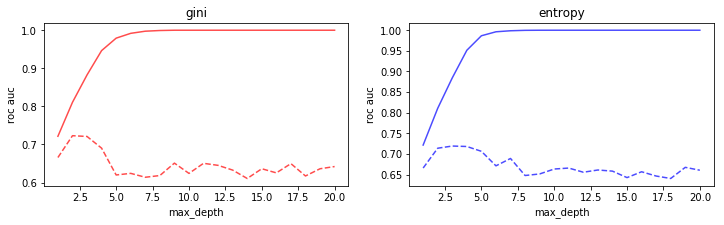

In [159]:
plt.figure(figsize=(12,3))
N = len(criterion)
for criterio, color in zip(criterion,['r','b']):
    i = criterion.index(criterio)
    plt.subplot(1,N,i+1)
    for sample, style in (('train','-'),('test','--')):
        plt.plot(max_depth, grid.cv_results_['mean_%s_score' % (sample)][grid.cv_results_['param_criterion'] == criterio],
                 style, color=color, alpha=0.7, label="%s" % (sample))
    plt.title(criterio)
    plt.xlabel('max_depth')
    plt.ylabel('roc auc')
plt.show()

Parece que max_depth funciona mejor entre 2 y 5

In [165]:
#param_grid = {'max_depth': list(range(1,11)),
#              'criterion': ['gini', 'entropy'],
#              'min_samples_split': [2, 10, 20],
#              'min_samples_leaf': [1, 5, 10],
#              'max_leaf_nodes': [None, 5, 10, 20],
#              }

min_samples_split = list(range(2,201,2))
criterion = ['gini', 'entropy']
param_grid = dict(min_samples_split=min_samples_split, criterion=criterion)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,... 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

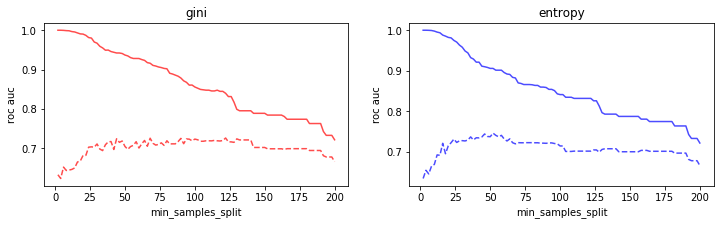

In [166]:
plt.figure(figsize=(12,3))
N = len(criterion)
for criterio, color in zip(criterion,['r','b']):
    i = criterion.index(criterio)
    plt.subplot(1,N,i+1)
    for sample, style in (('train','-'),('test','--')):
        plt.plot(min_samples_split, grid.cv_results_['mean_%s_score' % (sample)][grid.cv_results_['param_criterion'] == criterio],
                 style, color=color, alpha=0.7, label="%s" % (sample))
    plt.title(criterio)
    plt.xlabel('min_samples_split')
    plt.ylabel('roc auc')
plt.show()

In [172]:
#param_grid = {'max_depth': list(range(1,11)),
#              'criterion': ['gini', 'entropy'],
#              'min_samples_split': [2, 10, 20],
#              'min_samples_leaf': [1, 5, 10],
#              'max_leaf_nodes': [None, 5, 10, 20],
#              }

min_samples_leaf = list(range(1,101))
criterion = ['gini', 'entropy']
param_grid = dict(min_samples_leaf=min_samples_leaf, criterion=criterion)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=

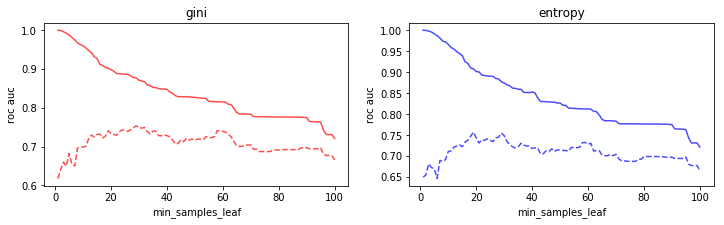

In [173]:
plt.figure(figsize=(12,3))
N = len(criterion)
for criterio, color in zip(criterion,['r','b']):
    i = criterion.index(criterio)
    plt.subplot(1,N,i+1)
    for sample, style in (('train','-'),('test','--')):
        plt.plot(min_samples_leaf, grid.cv_results_['mean_%s_score' % (sample)][grid.cv_results_['param_criterion'] == criterio],
                 style, color=color, alpha=0.7, label="%s" % (sample))
    plt.title(criterio)
    plt.xlabel('min_samples_leaf')
    plt.ylabel('roc auc')
plt.show()

In [176]:
#param_grid = {'max_depth': list(range(1,11)),
#              'criterion': ['gini', 'entropy'],
#              'min_samples_split': [2, 10, 20],
#              'min_samples_leaf': [1, 5, 10],
#              'max_leaf_nodes': [None, 5, 10, 20],
#              }

max_leaf_nodes = list(range(2,21))
criterion = ['gini', 'entropy']
param_grid = dict(max_leaf_nodes=max_leaf_nodes, criterion=criterion)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

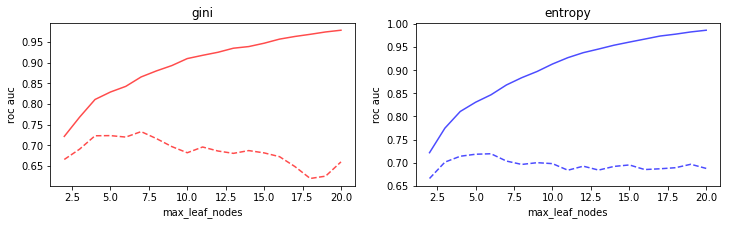

In [177]:
plt.figure(figsize=(12,3))
N = len(criterion)
for criterio, color in zip(criterion,['r','b']):
    i = criterion.index(criterio)
    plt.subplot(1,N,i+1)
    for sample, style in (('train','-'),('test','--')):
        plt.plot(max_leaf_nodes, grid.cv_results_['mean_%s_score' % (sample)][grid.cv_results_['param_criterion'] == criterio],
                 style, color=color, alpha=0.7, label="%s" % (sample))
    plt.title(criterio)
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('roc auc')
plt.show()

Que tal si hacemos un random search con param_dist abarcando muchas posibilidades, y despues un grid search con param_grid mas focalizado en la zona en la que dio bien el random search?

Revisar mejor que son los parametros del decision tree classifier y los tips de decision trees en la documentacion de sklearn

    Tener cuidado con el CV, quizas conviene predefinir el cv en lugar de tirarle el numero de folds asi siempre usa el mismo

## LDA

Supuestamente no tiene hyperparametros para tunear

In [198]:
solver = ['svd','lsqr','eigen']
n_components = list(range(0,201,20))
param_grid = dict(solver=solver, n_components=n_components)
#cv = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
grid = sklearn.model_selection.GridSearchCV(lda,param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

#print("The best parameters are %s with a score of %0.2f"
#      % (grid.best_params_, grid.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'solver': ['svd', 'lsqr', 'eigen'], 'n_components': [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [199]:
grid.best_estimator_

LinearDiscriminantAnalysis(n_components=0, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

## Naive Bayes

Supuestamente no tiene hyperparametros para tunear

Se puede buscar para distintos valores de var_smoothing o de prior, que creo q sería cuanto peso le das a cada feature

    Ojo: El parametro var_smoothing no era un input en versiones anteriores, hay que actualizar sklearn

In [ ]:
var_smoothing = np.logspace(-10, 1, 12)
param_grid = dict(var_smoothing=var_smoothing)
nb = sklearn.naive_bayes.GaussianNB()
grid = sklearn.model_selection.GridSearchCV(nb, param_grid=param_grid, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())
#nb.fit(X_dev, y_dev.values.ravel())

In [ ]:
plt.figure(figsize=(10,4))
for fold, color in zip(list(range(0,5)),['r','g','b','c','y']):
    for sample, style in (('train','-'),('test','--')):
        plt.plot(grid.cv_results_['split%s_%s_score' % (fold, sample)], style, 
                 color=color, alpha=0.7, label="%s (%s)" % (fold, sample))
        plt.xticks(range(0,len(var_smoothing)+1),labels=var_smoothing)
plt.legend(title='splits', loc= 'center left')
plt.show()

In [ ]:
plt.plot(grid.cv_results_['mean_train_score'])
plt.plot(grid.cv_results_['mean_test_score'],'--')
plt.xticks(range(0,len(var_smoothing)+1),labels=var_smoothing)
plt.xlabel('Value of var_smoothing for NB')
plt.ylabel('Cross-Validated Accuracy')
plt.legend(('train','test'))
plt.show()

No se si conviene elegir un parametro distinto al default que es 1e-09

## SVM

Para SVM, C desde 0.01 a 100 de a potencias de 10 o param = {"C": np.logspace(-2,2,5)} qu va de 0.01 a 100. O en este ejemplo un rango mas amplio

In [ ]:
C_range = np.logspace(-2, 5, 8)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(), param_grid=param_grid, scoring='roc_auc', cv=cv, iid='True')
grid.fit(X_dev, y_dev.values.ravel())

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [ ]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))

In [ ]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [ ]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
    values='mean_test_score', index='param_C', columns='param_gamma')

import seaborn as sns       
ax = sns.heatmap(pvt)

In [ ]:
heatmap = sns.heatmap(pvt, square=True, annot=True, fmt=".2f", cbar=False)

Grid search CV

In [203]:
def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

Hay que reformularlo todo

In [ ]:
########################################################
## AQUI VA SU CODIGO 
#n_neighbors = range(1, 101) # Parametros k de KNN
#
#cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
#splits = cv.split(X_dev, y_dev)
#for train_idxs, val_idxs in splits:
#    knn = KNeighborsClassifier(n_neighbors=k)
#    knn.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
#    lda = LinearDiscriminantAnalysis()
#    lda.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
#    tree = DecisionTreeClassifier(max_depth=3)
#    tree.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
#    nb = GaussianNB()
#    nb.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
#    svm = LinearSVC()
#    svm.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
#    y_train = y_dev.iloc[train_idxs]
#    y_val = y_dev.iloc[val_idxs]
#    y_train_pred_tree = tree.predict(X_dev.iloc[train_idxs])
#    y_val_pred_tree = tree.predict(X_dev.iloc[val_idxs])
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba
########################################################

La siguiente celda la converti en markdown para que no la corra porque no anda

In [196]:
########################################################
## AQUI VA SU CODIGO 
## Modelos
knn = sklearn.neighbors.KNeighborsClassifier()
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
tree = sklearn.tree.DecisionTreeClassifier()
nb = sklearn.naive_bayes.GaussianNB()
svm = sklearn.svm.LinearSVC()
#estimator = [knn,lda,tree,nb,svm]
#estimator = dict(clf=[knn,lda,tree,nb,svm])
## Parametros
n_neighbors = range(1, 101) # Parametros k de KNN
criterion = ['gini', 'entropy'] # tree
#min_samples_split = [2, 10, 20] # tree
max_depth = np.arange(3, 10) # tree
#min_samples_leaf = [1, 5, 10] # tree
#max_leaf_nodes = [None, 5, 10, 20] # tree
C = np.logspace(-2, 5, 8) # SVM
gamma = np.logspace(-9, 3, 13) # SVM
#param_grid = dict(n_neighbors=n_neighbors, criterion=criterion, max_depth=max_depth, gamma=gamma, C=C)
param_grid = {'clf': [knn,lda,tree,nb,svm]}
pipeline = sklearn.pipeline.Pipeline([
    ('clf', sklearn.svm.LinearSVC())
])
grid = sklearn.model_selection.GridSearchCV(pipeline, param_grid=estimator, cv=5, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel())

## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba
########################################################

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='True', n_jobs=None,
       param_grid={'clf': [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_cov...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [197]:
print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(memory=None,
     steps=[('clf', GaussianNB(priors=None, var_smoothing=1e-09))])
0.735


O mejor a mano

    Ojo que aparentemente linear svc no tiene gamma

In [207]:
names = [
         'KNN',
         'LDA',
         'Tree',
         'NB',
         'SVM'
        ]

classifiers = [
    sklearn.neighbors.KNeighborsClassifier(),
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis(),
    sklearn.tree.DecisionTreeClassifier(),
    sklearn.naive_bayes.GaussianNB(),
    sklearn.svm.LinearSVC()
]

parameters = [
              {'clf__n_neighbors': list(range(1, 101))},
              {'clf__solver': ['svd','lsqr','eigen']},
              {'clf__max_depth': list(range(1,11))},
              {'clf__var_smoothing': [1e-09,1e-08,1e-07]},
              {'clf__C': np.logspace(-2, 5, 8)}
             ]

for name, classifier, params in zip(names, classifiers, parameters):
    clf_pipe = sklearn.pipeline.Pipeline([
        ('clf', classifier),
    ])
    gs_clf = GridSearchCV(clf_pipe, param_grid=params, cv=5, scoring='roc_auc', iid='True')
    clf = gs_clf.fit(X_dev, y_dev.values.ravel())
    top_resultados(gs_clf)
    

Top 5 combinaciones


,clf__n_neighbors,mean_score_validation,mean_score_training
62,63,0.8471,0.8511
59,60,0.8461,0.8517
60,61,0.8461,0.8522
61,62,0.8454,0.8509
63,64,0.8433,0.8507


Top 5 combinaciones


,clf__solver,mean_score_validation,mean_score_training
0,svd,0.6627,0.9961
1,lsqr,0.6627,0.9961
2,eigen,0.6627,0.9961


Top 5 combinaciones


,clf__max_depth,mean_score_validation,mean_score_training
2,3,0.7288,0.8826
1,2,0.7230,0.8107
3,4,0.6928,0.9431
0,1,0.6657,0.7215
7,8,0.6503,0.9996


Top 5 combinaciones


,clf__var_smoothing,mean_score_validation,mean_score_training
0,1.0000e-09,0.8285,0.8682
1,1.0000e-08,0.8285,0.8682
2,1.0000e-07,0.8285,0.8682


Top 5 combinaciones


,clf__C,mean_score_validation,mean_score_training
0,0.01,0.7897,0.9965
1,0.10,0.7503,1.0000
2,1.00,0.7384,1.0000
5,1000.00,0.7382,1.0000
6,10000.00,0.7382,1.0000


#### Conclusiones Grid Search

< < COMPLETAR > >

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




1. Hacer curvas de performance (auc roc) sobre el dev set y el eval set en funcion del max depth (arboles) o del C (svm) (curva de complejidad)
2. Hacer curvas de performance (auc roc) sobre el dev set y el eval set en funcion del numero de instancias (curva de aprendizaje)
3. Random Forest con 200 arboles. Curva de complejidad para max_features. Grid search y Curva de aprendizaje.

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
